In [1]:
# load package
import pandas as pd
import numpy as np
import lightgbm as lgb
#from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import cross_validation


# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/InClass Prediction Competition/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')
#你可以选择修改 ast_note_iteractively kernel 选项来使得 Jupyter 为每一行的变量或语句执行这个操作，以便你可以立即看到多条语句一起输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train= pd.read_csv('train.csv',encoding='big5')
class1 = train[train.Class==1]
class0 = train[train.Class==0]

In [3]:
train= class0.append([class1,class1,class1], ignore_index=True)
test= pd.read_csv('test_public.csv',encoding='big5')
# append in ONE data
test = test.dropna()
data=train.append(test, ignore_index=True)

In [4]:
data['s_in_a_Day']= data['Time']%(60*60*24)
import math
data['h_in_a_Day']= data['s_in_a_Day'].map(lambda x: math.floor(x/(60*60)))

In [ ]:
for a in ['s_in_a_Day']:
    series=data[a]
    bins= np.percentile(series, [10, 20, 30, 40, 50, 60, 70, 80, 90])
    series =np.digitize(series, bins, right=False)
    data[a]=series

In [5]:
data.head()

,Amount,Class,TXKEY,Time,V1,V10,V11,V12,V13,V14,...,V28,V3,V4,V5,V6,V7,V8,V9,s_in_a_Day,h_in_a_Day
0,520.12,0.0,T49906,44261.0,0.339812,-0.565012,-0.087670,0.979427,0.076883,-0.217884,...,0.102038,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,44261.0,12
1,31.00,0.0,T29474,35484.0,1.399590,0.756801,0.543827,0.112453,1.075384,-0.245772,...,0.004634,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,35484.0,9
2,1.50,0.0,T276481,167123.0,-0.432071,-1.376648,-1.328335,0.223621,1.132627,-0.550875,...,0.001934,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,80723.0,22
3,0.89,0.0,T278846,168473.0,2.014160,0.259452,0.942162,0.850038,-0.616166,0.592634,...,-0.070571,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,82073.0,22
4,100.00,0.0,T101565,67878.0,-0.641330,-2.084080,0.480381,0.473738,-2.192276,0.773942,...,0.180357,1.489998,-1.688131,-1.151043,0.259996,-1.391069,-2.334075,1.168644,67878.0,18


In [7]:
# 運用'Class'欄位來判斷訓練集還是測試集
dataTrain = data[pd.notnull(data['Class'])].sort_values(by=["Time"])
dataTest = data[~pd.notnull(data['Class'])].sort_values(by=["Time"])
dataTrain.columns

Index(['Amount', 'Class', 'TXKEY', 'Time', 'V1', 'V10', 'V11', 'V12', 'V13',
       'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V3', 'V4', 'V5', 'V6', 'V7',
       'V8', 'V9', 's_in_a_Day', 'h_in_a_Day'],
      dtype='object')

In [8]:
dataTrain = dataTrain.drop(['s_in_a_Day'], axis=1)#,'s_in_a_Day', 'h_in_a_Day'
dataTest = dataTest.drop(['TXKEY','Class','s_in_a_Day'], axis=1)
X_feature = dataTrain.drop(['TXKEY','Class'], axis=1)
y_t =dataTrain['Class']

In [9]:
#把上面dataTrain.columns的結果貼到dataTrain，再去掉'Survived'
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.33, random_state=2884)

In [10]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [11]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators = 150, random_state=0) #, objective = 'binary'


param_grid = {
    'objective':['binary'],
    'learning_rate': [0.04,0.05], 
    'num_leaves': [128],
    'feature_fraction': [0.7],
    'bagging_fraction': [0.95],
    'max_depth':[7],
    #'max_bin': [6],
    'bagging_freq':[5],
    'lambda_l1': [0.1] , #[44,133] then 44 [44,88] then 44 np.arange(38,44,1) np.arange(16,20,1)
    'lambda_l2': [0.02,0.04] ,#np.arange(11,15,1) then 13
    #'reg_alpha':[4,10] ,
    #'min_split_gain': [0.04], 
    'min_child_weight': [2] 
}

LGBM_grid = GridSearchCV(estimator, param_grid,scoring='recall',cv=4)#,cv=4
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators = 150, random_state=0 ,
                                     objective = LGBM_grid.best_params_['objective'],
                                     learning_rate = LGBM_grid.best_params_['learning_rate'],
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                             bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              #max_bin = LGBM_grid.best_params_['max_bin'],
                                bagging_freq = LGBM_grid.best_params_['bagging_freq'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                              #reg_alpha = LGBM_grid.best_params_['reg_alpha'],
                            #min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight']
                                    )
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print("Predicting is over")

Start training...


GridSearchCV(cv=4, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=150,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'objective': ['binary'], 'learning_rate': [0.04, 0.05], 'num_leaves': [128], 'feature_fraction': [0.7], 'bagging_fraction': [0.95], 'max_depth': [7], 'bagging_freq': [5], 'lambda_l1': [0.1], 'lambda_l2': [0.02, 0.04], 'min_child_weight': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

Best parameters found by grid search are: {'bagging_fraction': 0.95, 'bagging_freq': 5, 'feature_fraction': 0.7, 'lambda_l1': 0.1, 'lambda_l2': 0.04, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 2, 'num_leaves': 128, 'objective': 'binary'}
Start predicting...
Predicting is over


Accuracy:1.000
Classification report
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     65688
        1.0       0.97      0.94      0.96       323

avg / total       1.00      1.00      1.00     66011

Confusion matrix
[[65679     9]
 [   19   304]]
ROC AUC Score
0.9990917756253127
Feature importances: [153, 110, 128, 173, 121, 131, 110, 212, 101, 100, 119, 91, 108, 102, 102, 121, 97, 96, 142, 84, 146, 98, 122, 109, 209, 95, 69, 135, 122, 124, 74]
Plot feature importances...


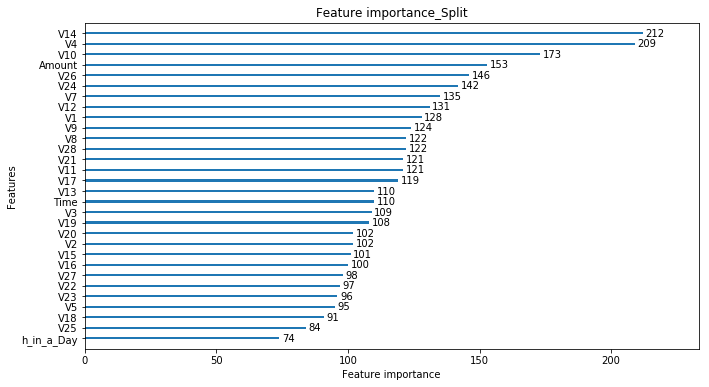

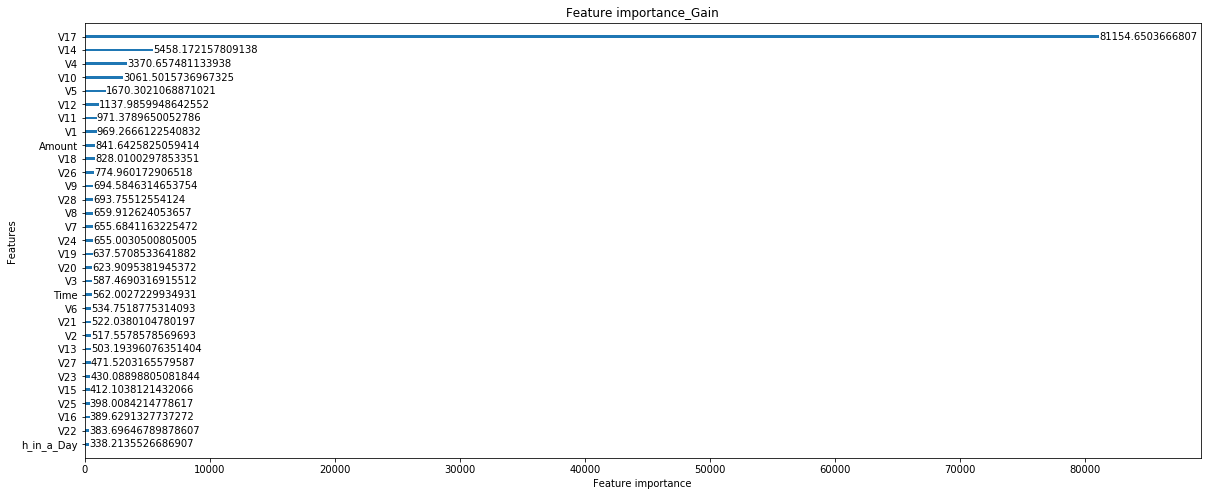

In [12]:
#對test算performance
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
split_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, ignore_zero=False,figsize=(11, 6),grid=False, title='Feature importance_Split')
gain_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=40, importance_type='gain',figsize=(20, 8),grid=False, title='Feature importance_Gain')


In [13]:
#對test算 f1_score
from sklearn.metrics import f1_score
y_pred_val = LGBM_grid_final_fit.predict(X_test)
f1_score(y_test,y_pred_val,average=None)

array([0.99978689, 0.95597484])

In [14]:
def get_lift(prob_data):
    prob_data=prob_data.sort_values(by=['Prob'],ascending=False).reset_index(drop=True)
    prob_data['cnt']=1.0
    prob_data['cumsum']=prob_data.Y.cumsum()
    prob_data['cum_cnt'] = prob_data.cnt.cumsum()
    prob_data['precision'] = prob_data['cumsum']/prob_data['cum_cnt']
    prob_data['recall'] = prob_data['cumsum']/prob_data['cumsum'].max()
    lift_data = prob_data[['precision','recall']].groupby(['recall']).min().reset_index()
    lift_data['f1'] = (2*lift_data.precision*lift_data.recall)/(lift_data.precision+lift_data.recall)
    return lift_data

In [15]:
result = pd.DataFrame(data={'Y':y_test,'Prob':y_pred_val})
result_lift = get_lift(result)

In [16]:
result_lift=result_lift.iloc[1:,:]
result_lift[result_lift.f1==result_lift.f1.max()]

,recall,precision,f1
302,0.93808,0.971154,0.954331


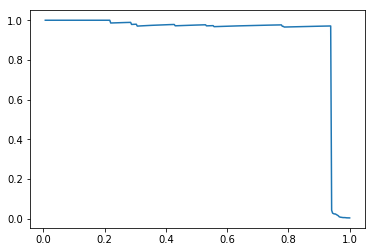

In [17]:
plt.plot(result_lift.recall,result_lift.precision)

In [18]:
#拿全部的dataTrain來建
LGBM_grid_final_fit_all = LGBM_grid_final.fit(X_feature, y_t)

In [19]:
LGBM_grid_final_fit_res =LGBM_grid_final_fit_all.predict_proba(dataTest)

In [20]:
df_p = pd.DataFrame({'p0':LGBM_grid_final_fit_res[:,0],'p1':LGBM_grid_final_fit_res[:,1]})

In [21]:
submit = pd.read_csv('sampleSubmission.csv',encoding='big5')
out = pd.concat([submit, df_p], axis=1, ignore_index=True)
out.sort_values(by=[3], ascending=False, inplace=True)
out.rename(columns={0:'TXKEY', 1:'Class', 2:'p0', 3:'p1'},inplace=True)
print('偽冒機率門檻：',out.iloc[137,3])
out.Class[out.p1>=out.iloc[137,3]]=1

偽冒機率門檻： 0.5364648330154215


In [22]:
out=out[['TXKEY','Class']]
out.to_csv("submit.csv", index= False)